**Ejemplo de identificación de perros y gatos en imágenes digitales**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2


In [3]:
#The database is downloaded
#More detail here: https://github.com/tensorflow/datasets/issues/3918

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

#Descargar el set de datos de perros y gatos:
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteUTVJFA/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmp5fyaetontfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
   

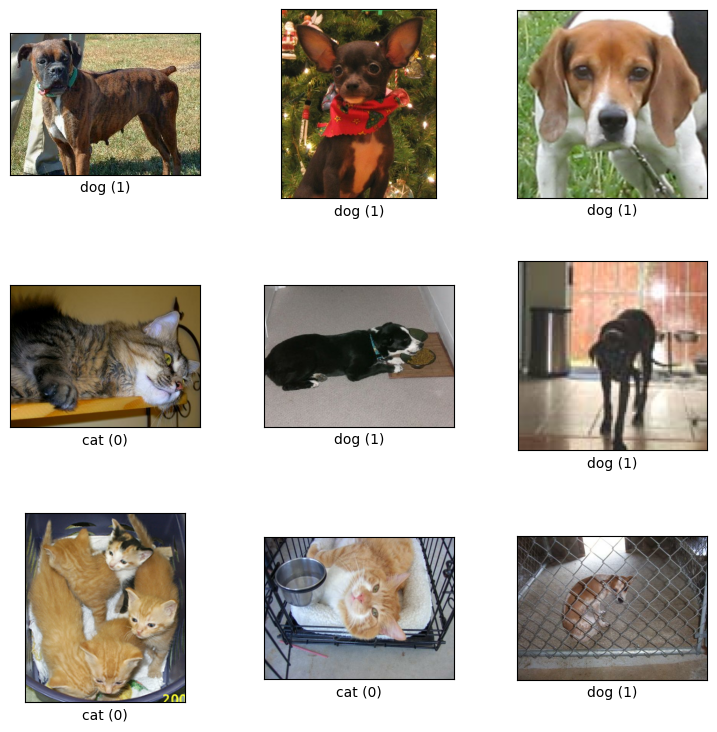

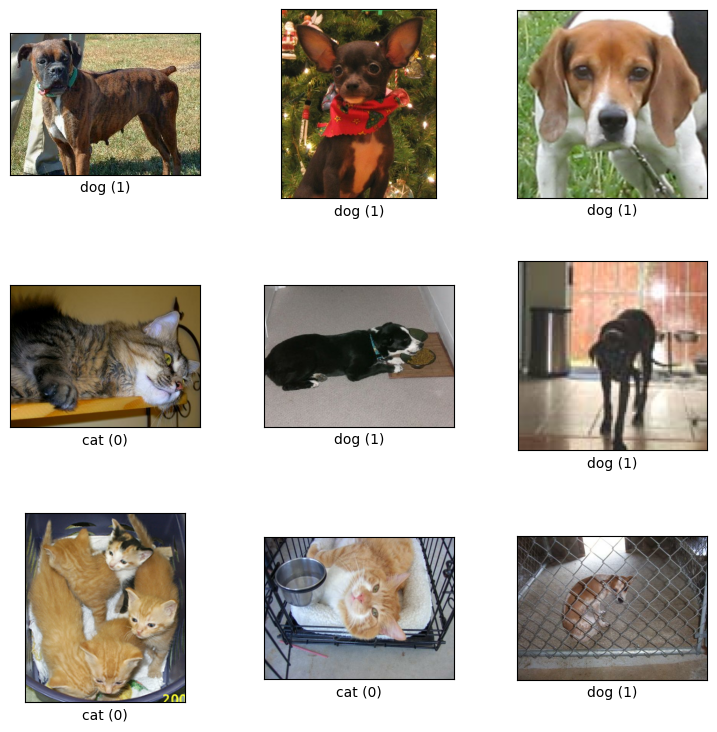

In [4]:
#Print the metadata for review and examples are shown:
print(metadatos)

#Show examples of the set:
tfds.show_examples(datos['train'], metadatos)

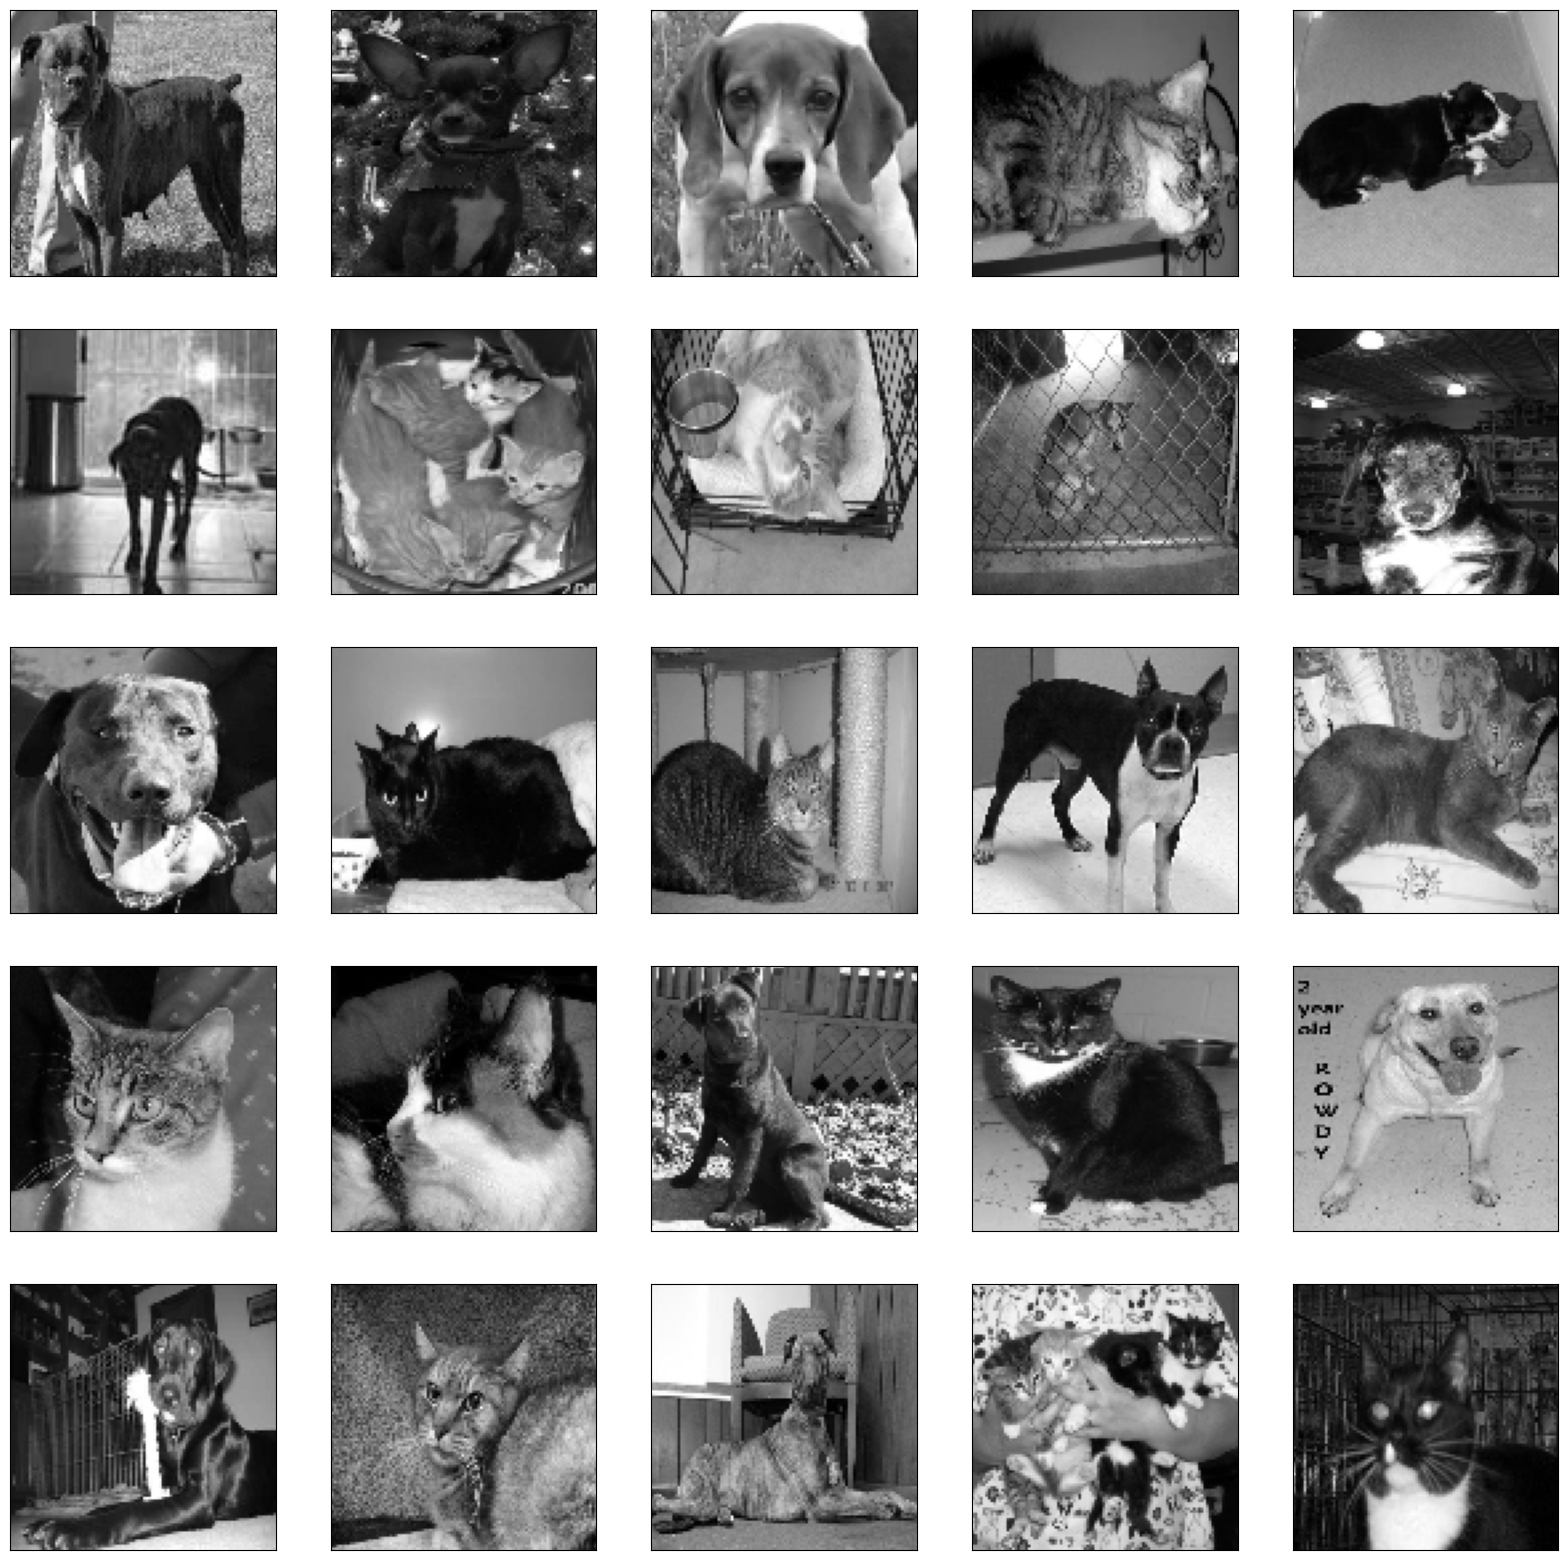

In [5]:
#Pre-processing of images
#We change it to IMG_SIZE (100x100) and grayscale (25 imagenes only for visualization):

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [6]:
#Variable that will contain all pairs of data (image and label) already modified (grayscale, 100x100):
datos_BD = []

for i, (imagen, etiqueta) in enumerate(datos['train']): #All data
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Change size to 100,100,1
  datos_BD.append([imagen, etiqueta])

In [7]:
#Separate variables X (inputs), and (labels) are prepared:

X = [] #input images (pixels)
y = [] #tags (dog or cat)

for imagen, etiqueta in datos_BD:
  X.append(imagen)
  y.append(etiqueta)

#The X data (images) are normalized. They are converted to a floating number and divided by 255 to get 0-1 instead of 0-255.
X = np.array(X).astype(float) / 255

#Labels are converted into a numpy array:
y = np.array(y)

print('Full database size:',X.shape)
#print(X[0,:,:,0])
print('Labels: ',y)

Full database size: (23262, 100, 100, 1)
Labels:  [1 1 1 ... 0 1 0]


In [8]:
#Initial models are created
#Sigmoid activation function is used as output (instead of softmax).
#Sigmoid always returns data between 0 and 1. We carry out the training where it is considered that if the response is
#closes to 0, it is a cat, and if it approaches 1, it is a dog.

# Model 1
#Multilayer perceptron Model (MLP):
#Is a fully connected architecture

modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(TAMANO_IMG, TAMANO_IMG, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid') # Output layer

  #In the final layer, sigmoid activation is used because the problem consists
  #of a binary classification problem, allowing for an output between 0 and 1
  #Also, appreciate that just 1 neuron is fixed in the final layer (binary class problem)
  #If the problem is a multiclass problem, softmax is used.

])

# Model 2
#Convolutional Neuronal Network Model (CNN):
modeloCNN = tf.keras.models.Sequential([

  #In CNN, we talk about number of filters (no number of neurons)
  #32,64,128 = Are hte number of desired fiture maps in the outpu. (3,3) the size of the window

  #1 image in the input, 32 fiture maps in the output(32 images)
  tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same',input_shape=(TAMANO_IMG, TAMANO_IMG, 1)),
  #Mazpooling2D reduces the dimensionality
  tf.keras.layers.MaxPooling2D(2, 2),
  #32 images in the intput (the fiture maps) and 64 fiture maps in the output = 2 filters.
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  #64 images in the intput (the fiture maps) and 128 fiture maps in the output = 3 filters.
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  #Dropout makes the architecture partially connected, avoiding overfiting
  #Randomly Dropout disconnect some neurons.
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

print(modeloCNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 11, 11, 128)      

In [9]:
adam=keras.optimizers.Adam(learning_rate=0.01)
#The models are compiled. Binary crossentropy is used since we have only 2 classes (dog or cat)
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [10]:
#The dense model is trained and validated:
historyMLP = modeloDenso.fit(X, y, batch_size=32,
                validation_split=0.15,
                #epochs, is the number of trainings
                epochs=30)

Epoch 1/30
618/618 [==============================] - 9s 5ms/step - loss: 0.7242 - accuracy: 0.5501 - val_loss: 0.7047 - val_accuracy: 0.5158
Epoch 2/30
618/618 [==============================] - 3s 5ms/step - loss: 0.6723 - accuracy: 0.5845 - val_loss: 0.6733 - val_accuracy: 0.5837
Epoch 3/30
618/618 [==============================] - 3s 5ms/step - loss: 0.6657 - accuracy: 0.5939 - val_loss: 0.6687 - val_accuracy: 0.5926
Epoch 4/30
618/618 [==============================] - 3s 5ms/step - loss: 0.6633 - accuracy: 0.5996 - val_loss: 0.6771 - val_accuracy: 0.5742
Epoch 5/30
618/618 [==============================] - 3s 4ms/step - loss: 0.6597 - accuracy: 0.6077 - val_loss: 0.6719 - val_accuracy: 0.5762
Epoch 6/30
618/618 [==============================] - 3s 4ms/step - loss: 0.6573 - accuracy: 0.6093 - val_loss: 0.6654 - val_accuracy: 0.6043
Epoch 7/30
618/618 [==============================] - 3s 4ms/step - loss: 0.6582 - accuracy: 0.6080 - val_loss: 0.6732 - val_accuracy: 0.5751
Epoch 

In [11]:
#The CNN1 model is trained and validated:
historyCNN = modeloCNN.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=30)

Epoch 1/30
618/618 [==============================] - 18s 16ms/step - loss: 0.6376 - accuracy: 0.6235 - val_loss: 0.5630 - val_accuracy: 0.7074
Epoch 2/30
618/618 [==============================] - 9s 15ms/step - loss: 0.5100 - accuracy: 0.7479 - val_loss: 0.4667 - val_accuracy: 0.7805
Epoch 3/30
618/618 [==============================] - 10s 15ms/step - loss: 0.4410 - accuracy: 0.7945 - val_loss: 0.4336 - val_accuracy: 0.7968
Epoch 4/30
618/618 [==============================] - 9s 15ms/step - loss: 0.3982 - accuracy: 0.8203 - val_loss: 0.3952 - val_accuracy: 0.8238
Epoch 5/30
618/618 [==============================] - 9s 15ms/step - loss: 0.3568 - accuracy: 0.8430 - val_loss: 0.3576 - val_accuracy: 0.8401
Epoch 6/30
618/618 [==============================] - 9s 15ms/step - loss: 0.3253 - accuracy: 0.8543 - val_loss: 0.3458 - val_accuracy: 0.8438
Epoch 7/30
618/618 [==============================] - 9s 15ms/step - loss: 0.2928 - accuracy: 0.8712 - val_loss: 0.3566 - val_accuracy: 0.84

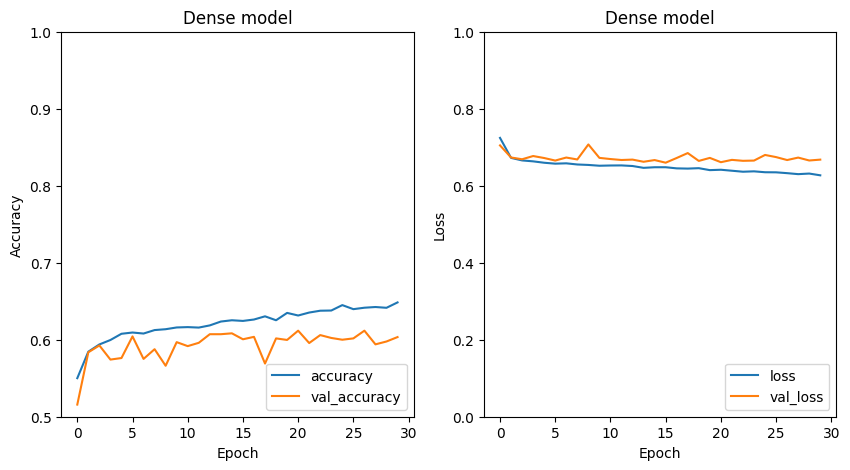

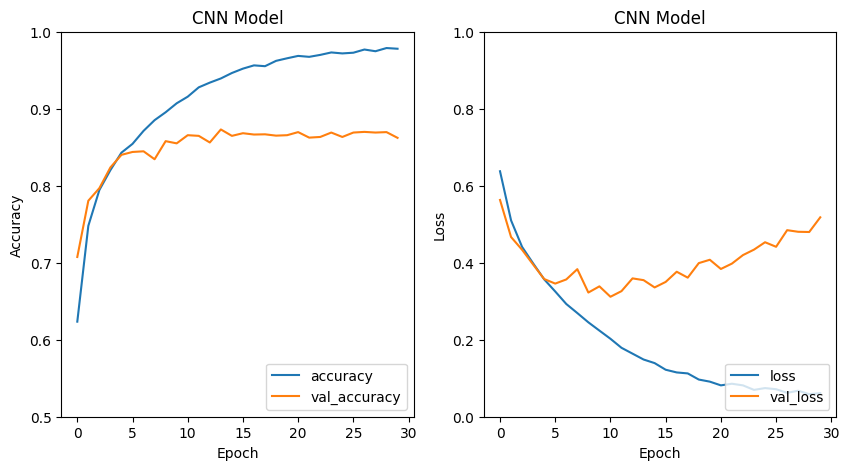

In [12]:
# The learning curves of the dense model are calculated and plotted:

plt.figure(figsize=(10,5))

#Accuracy Curve
plt.subplot(1,2,1)
plt.plot(historyMLP.history['accuracy'], label='accuracy')
plt.plot(historyMLP.history['val_accuracy'], label = 'val_accuracy')
plt.title('Dense model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Loss Curve
plt.subplot(1,2,2)
plt.plot(historyMLP.history['loss'], label='loss')
plt.plot(historyMLP.history['val_loss'], label = 'val_loss')
plt.title('Dense model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# The learning curves of the CNN model are calculated and plotted:
plt.figure(figsize=(10,5))

#Accuracy Curve
plt.subplot(1,2,1)
plt.plot(historyCNN.history['accuracy'], label='accuracy')
plt.plot(historyCNN.history['val_accuracy'], label = 'val_accuracy')
plt.title('CNN Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Loss Curve
plt.subplot(1,2,2)
plt.plot(historyCNN.history['loss'], label='loss')
plt.plot(historyCNN.history['val_loss'], label = 'val_loss')
plt.title('CNN Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

**The process is repeated with partition of the data into training and validation set**

In [13]:
#Partition is made into training and validation set (random Hold-Out):

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=None)

print('Training set size:',X_train.shape)
print('Validation set size::',X_test.shape)

# The dense and CNN models are created and compiled again:

#Multilayer perceptron (MLP):
modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

#(CNN):
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')#Output Layer
])

adam = keras.optimizers.Adam(learning_rate=0.01)
#The models are compiled. Binary crossentropy is used since we have only 2 classes (dog or cat)
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

Training set size: (19772, 100, 100, 1)
Validation set size:: (3490, 100, 100, 1)


In [14]:
#The dense model (MLP) is trained and validated:
HistoryMLP=modeloDenso.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/30
618/618 [==============================] - 4s 5ms/step - loss: 0.7194 - accuracy: 0.5477 - val_loss: 0.6800 - val_accuracy: 0.5728
Epoch 2/30
618/618 [==============================] - 3s 4ms/step - loss: 0.6756 - accuracy: 0.5731 - val_loss: 0.6670 - val_accuracy: 0.5845
Epoch 3/30
618/618 [==============================] - 3s 5ms/step - loss: 0.6706 - accuracy: 0.5913 - val_loss: 0.6641 - val_accuracy: 0.5948
Epoch 4/30
618/618 [==============================] - 4s 6ms/step - loss: 0.6657 - accuracy: 0.5946 - val_loss: 0.6678 - val_accuracy: 0.5914
Epoch 5/30
618/618 [==============================] - 3s 4ms/step - loss: 0.6679 - accuracy: 0.5919 - val_loss: 0.6665 - val_accuracy: 0.5974
Epoch 6/30
618/618 [==============================] - 3s 4ms/step - loss: 0.6635 - accuracy: 0.5982 - val_loss: 0.6742 - val_accuracy: 0.5693
Epoch 7/30
618/618 [==============================] - 3s 5ms/step - loss: 0.6604 - accuracy: 0.6045 - val_loss: 0.6728 - val_accuracy: 0.5840
Epoch 

In [15]:
# The CNN is trained and validated:
HistoryCNN=modeloCNN.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/30
618/618 [==============================] - 12s 17ms/step - loss: 0.6670 - accuracy: 0.5827 - val_loss: 0.6213 - val_accuracy: 0.6596
Epoch 2/30
618/618 [==============================] - 9s 14ms/step - loss: 0.5983 - accuracy: 0.6810 - val_loss: 0.5726 - val_accuracy: 0.6891
Epoch 3/30
618/618 [==============================] - 9s 15ms/step - loss: 0.5213 - accuracy: 0.7416 - val_loss: 0.4891 - val_accuracy: 0.7662
Epoch 4/30
618/618 [==============================] - 9s 15ms/step - loss: 0.4676 - accuracy: 0.7738 - val_loss: 0.4659 - val_accuracy: 0.7705
Epoch 5/30
618/618 [==============================] - 9s 15ms/step - loss: 0.4280 - accuracy: 0.8000 - val_loss: 0.4278 - val_accuracy: 0.7986
Epoch 6/30
618/618 [==============================] - 9s 15ms/step - loss: 0.3936 - accuracy: 0.8212 - val_loss: 0.4182 - val_accuracy: 0.8069
Epoch 7/30
618/618 [==============================] - 10s 15ms/step - loss: 0.3668 - accuracy: 0.8363 - val_loss: 0.3945 - val_accuracy: 0.81

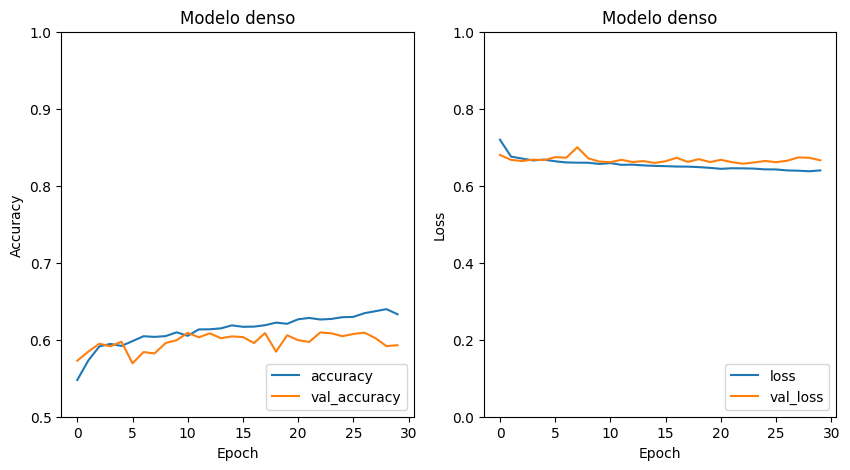

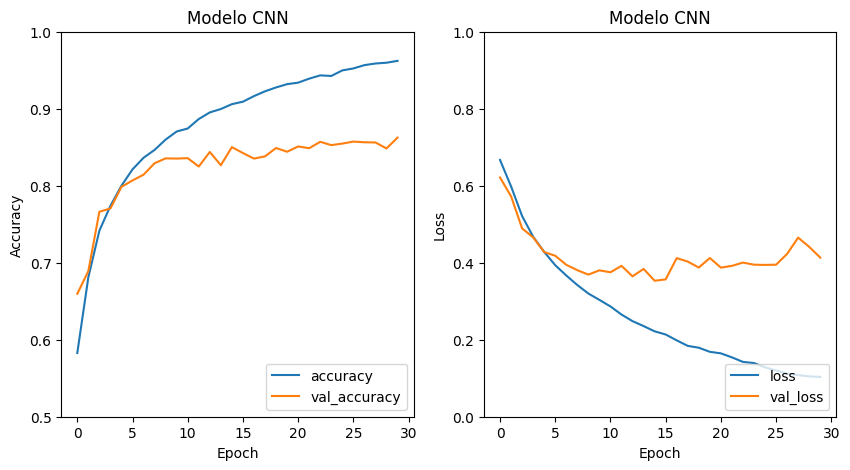

In [16]:
# The learning curves of the dense model are calculated and plotted:

plt.figure(figsize=(10,5))

#Accuracy Curve
plt.subplot(1,2,1)
plt.plot(HistoryMLP.history['accuracy'], label='accuracy')
plt.plot(HistoryMLP.history['val_accuracy'], label = 'val_accuracy')
plt.title('Modelo denso')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Loss Curve
plt.subplot(1,2,2)
plt.plot(HistoryMLP.history['loss'], label='loss')
plt.plot(HistoryMLP.history['val_loss'], label = 'val_loss')
plt.title('Modelo denso')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# The learning curves of the CNN model are calculated and plotted:

plt.figure(figsize=(10,5))

#Accuracy Curve
plt.subplot(1,2,1)
plt.plot(HistoryCNN.history['accuracy'], label='accuracy')
plt.plot(HistoryCNN.history['val_accuracy'], label = 'val_accuracy')
plt.title('Modelo CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Loss Curve
plt.subplot(1,2,2)
plt.plot(HistoryCNN.history['loss'], label='loss')
plt.plot(HistoryCNN.history['val_loss'], label = 'val_loss')
plt.title('Modelo CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

110/110 [==============================] - 0s 2ms/step
[[0.54718524]
 [0.05998942]
 [0.5916789 ]
 ...
 [0.54777586]
 [0.55549026]
 [0.4324773 ]]
[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]
 MLP Accuracy: 0.592836676217765
 Sensitivity (MLP): 0.5402298850574713
MLP:
              precision    recall  f1-score   support

           0       0.59      0.65      0.61      1750
           1       0.60      0.54      0.57      1740

    accuracy                           0.59      3490
   macro avg       0.59      0.59      0.59      3490
weighted avg       0.59      0.59      0.59      3490



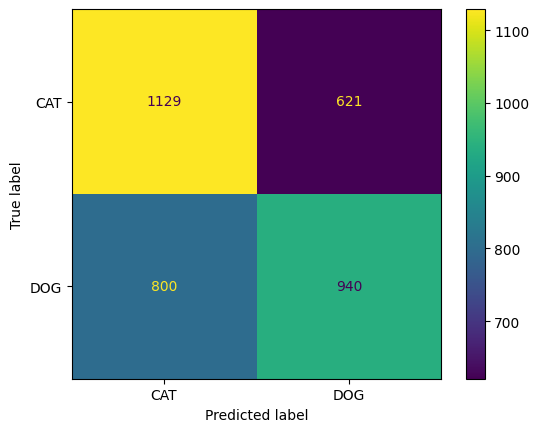

110/110 [==============================] - 0s 4ms/step
[[9.9963832e-01]
 [9.8368287e-02]
 [4.1859173e-03]
 ...
 [4.9566302e-01]
 [9.9399745e-01]
 [2.9469996e-07]]
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
CNN Accuracy : 0.8624641833810889
Sensitivity (CNN) : 0.8804597701149425
CNN:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1750
           1       0.85      0.88      0.86      1740

    accuracy                           0.86      3490
   macro avg       0.86      0.86      0.86      3490
weighted avg       0.86      0.86      0.86      3490



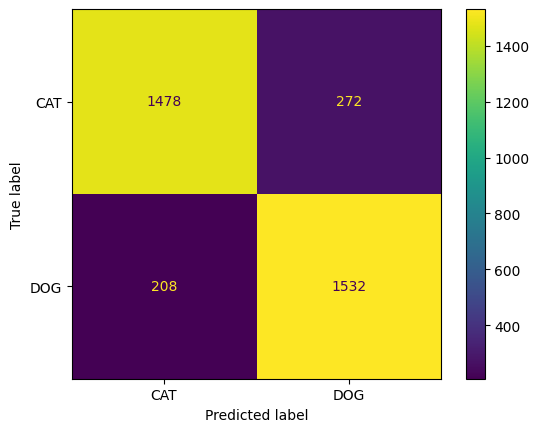

In [21]:
#Ranking metrics are calculated:
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
import sklearn.metrics as skm

# Predictions for the dense model (MLP):
y_pred=modeloDenso.predict(X_test)
print(y_pred)
y_pred=np.where(y_pred < 0.5, 0, 1)
print(y_pred)

#Accuracy MLP:
acc = accuracy_score(y_test, y_pred)
print(" MLP Accuracy:", acc)

#Sensitivity (Recall) MLP:
sens = recall_score(y_test, y_pred)
print(" Sensitivity (MLP):", sens)

#Calculate the classification report for MLP:
print('MLP:')
print(classification_report(y_test, y_pred))

#MLP confusion matrix:
cm = confusion_matrix(y_test, y_pred)
disp = skm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CAT','DOG'])
disp.plot()
plt.show()


# Predictions for CNN:
y_pred=modeloCNN.predict(X_test)
print(y_pred)
y_pred=np.where(y_pred < 0.5, 0, 1)
print(y_pred)

#Accuracy CNN:
acc = accuracy_score(y_test, y_pred)
print("CNN Accuracy :", acc)

#Sensitivity (Recall) CNN:
sens = recall_score(y_test, y_pred)
print("Sensitivity (CNN) :", sens)

#Calculate the ranking report for CNN:
print('CNN:')
print(classification_report(y_test, y_pred))

#CNN confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = skm.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CAT','DOG'])
disp.plot()
plt.show()

